In [1]:
# 添加项目目录
import sys
from pandas import Series
# 下面的import会导致
import se.infras
import logging
from se.domain2.domain import BeanContainer
from se.domain2.time_series.time_series import HistoryDataQueryCommand, TimeSeriesRepo, TimeSeries
if '/Users/zhang/PycharmProjects/strategy_engine_v2' not in sys.path:
    sys.path.append("/Users/zhang/PycharmProjects/strategy_engine_v2")

(MainThread) 2021-01-25 20:11:43 WARNING  connection.py:101 Cluster.__init__ called with contact_points specified, but no load_balancing_policy. In the next major version, this will raise an error; please specify a load-balancing policy. (contact_points = ['127.0.0.1'], lbp = None)
(MainThread) 2021-01-25 20:11:43 INFO     policies.py:289 Using datacenter 'datacenter1' for DCAwareRoundRobinPolicy (via host '127.0.0.1:9042'); if incorrect, please specify a local_dc to the constructor, or limit contact points to local cluster nodes


In [52]:
# 下载数据
import pandas as pd
start = pd.Timestamp("2019-06-10", tz='Asia/Shanghai')
end = pd.Timestamp("2020-12-01", tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, ['GSX_STK_USD_SMART'])
ts_repo: TimeSeriesRepo = BeanContainer.getBean(TimeSeriesRepo)
ts: TimeSeries = ts_repo.find_one("ibMinBar")
ts.download_data(command)
print(ts.data_record)


KeyboardInterrupt: 

In [13]:
# 计算日内回报、日间回报、以及总回报序列
start = pd.Timestamp("2019-06-01", tz='Asia/Shanghai')
end = pd.Timestamp("2020-12-01", tz='Asia/Shanghai')
command = HistoryDataQueryCommand(start, end, ['GSX_STK_USD_SMART'])
df = ts.history_data(command, from_local=True)
df = df.droplevel(level=1)
# 注意origin的tz必须跟原始的DataFrame的DatetimeIndex的timezone相同
df = df.resample('1D', origin=pd.Timestamp("2020-01-01 21:00:00", tz='Asia/Shanghai'))\
    .agg({'open': 'first', 'close': 'last'}).dropna()
close_to_open_rets = (df['open'].shift(-1) - df['close']) / df['close']
close_to_close_rets = (df['close'].shift(-1) - df['close']) / df['close']
open_to_close_rets = (df['close'] - df['open']) / df['open']

,oc,co,cc
visible_time,,,
2020-11-23 21:00:00+08:00,8.035247,-0.676461,1.976670
2020-11-24 21:00:00+08:00,8.242628,-0.675318,1.853156
2020-11-25 21:00:00+08:00,7.827913,-0.670632,1.910339
2020-11-27 21:00:00+08:00,7.876747,-0.670632,1.931382
2020-11-30 21:00:00+08:00,7.940930,NaN,NaN


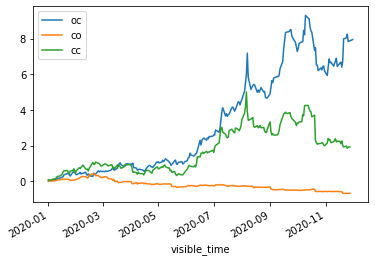

In [15]:
# 计算累计收益曲线
dd = pd.DataFrame({"oc":(1+open_to_close_rets).cumprod() - 1, "co":(1+close_to_open_rets).cumprod() - 1,
                   "cc": (1+close_to_close_rets).cumprod() - 1})
dd.plot()
dd.tail(5)

In [33]:
# close_to_open 与下一个 open_to_close 之间的相关性
df = pd.DataFrame({"co": close_to_open_rets, 'oc': open_to_close_rets.shift(-1)}).dropna()
df.describe()

,co,oc
count,231.000000,231.000000
mean,-0.004046,0.010866
std,0.037577,0.052605
min,-0.219199,-0.165327
25%,-0.015854,-0.021744
50%,0.000833,0.009466
75%,0.012094,0.039206
max,0.130145,0.209021


In [49]:
profit_rets = open_to_close_rets[open_to_close_rets>0]
loss_rets = open_to_close_rets[open_to_close_rets<0]
print("open_to_close, profit rate:{}, profit mean:{}, loss mean:{}".format(
    len(profit_rets)/float(len(open_to_close_rets)),
    profit_rets.mean(),
    loss_rets.mean()
))

profit_rets = close_to_close_rets[close_to_close_rets>0]
loss_rets = close_to_close_rets[close_to_close_rets<0]
print("close_to_close, profit rate:{}, profit mean:{}, loss mean:{}".format(
    len(profit_rets)/float(len(close_to_close_rets)),
    profit_rets.mean(),
    loss_rets.mean()
))

open_to_close, profit rate:0.603448275862069, profit mean:0.0417929362874068, loss mean:-0.03626457229268872
close_to_close, profit rate:0.5344827586206896, profit mean:0.04689078433108469, loss mean:-0.04033103071371096


In [34]:
df.corr()


,co,oc
co,1.000000,-0.145558
oc,-0.145558,1.000000


In [36]:
# 统计不同的close_to_open的水平下， open_to_close的统计量，包括平均回报、胜率、方差、平均盈利、平均亏损
df = pd.DataFrame({"co": close_to_open_rets, 'oc': open_to_close_rets.shift(-1)}).dropna()
bins = [-0.21, -0.1, -0.05, -0.025, 0, 0.025, 0.05, 0.1, 0.15]
df['co_bins'] = pd.cut(df['co'], bins)
oc_grouped = df.groupby('co_bins').oc
oc_result = pd.DataFrame({"oc_mean": oc_grouped.mean(),
                                  "oc_count": oc_grouped.count(),
                                  "oc_std": oc_grouped.std()})
oc_result

,oc_mean,oc_count,oc_std
co_bins,,,
"(-0.21, -0.1]",0.075947,5,0.060507
"(-0.1, -0.05]",0.049587,8,0.067085
"(-0.05, -0.025]",0.006233,24,0.044653
"(-0.025, 0.0]",0.010938,77,0.052134
"(0.0, 0.025]",0.010863,92,0.046515
"(0.025, 0.05]",0.001552,15,0.062302
"(0.05, 0.1]",-0.017355,8,0.063682
"(0.1, 0.15]",-0.028982,1,NaN


<AxesSubplot:xlabel='visible_time'>

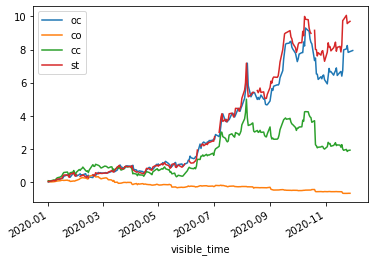

In [41]:
# 当close_to_open小于0.025的时候，在当天开盘的时候买入，持有到收盘卖出
dd = pd.DataFrame({"oc":(1+open_to_close_rets).cumprod() - 1, "co":(1+close_to_open_rets).cumprod() - 1,
                   "cc": (1+close_to_close_rets).cumprod() - 1})
df = pd.DataFrame({"co": close_to_open_rets, 'oc': open_to_close_rets.shift(-1)}).dropna()
dd['st'] = (1+df[df['co']<0.05]['oc']).cumprod()-1
dd.plot()


<AxesSubplot:xlabel='visible_time'>

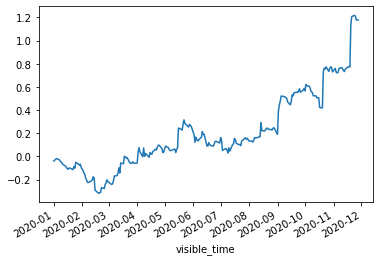

In [44]:
# 收盘做空，第二天平仓的累计收益曲线
((1-close_to_open_rets).cumprod()-1).plot()

0.006489337535443421